In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Experiment
ampl = np.array([[5188, 4571, 5012], 
                [4624, 4266, 4732], 
                [4571, 3631, 3758]])
phase = np.array([[0, 11, -30], 
                  [-12, 0, -30], [140, 0 ,0]])
phase0 = np.array([[23, 34, -7], 
                  [-12, 0, -30], [108, -112, -112]])
H_exp = ampl @ np.exp(-1j*phase0/57.3)


In [17]:
def dist(p1, p2):
    d = 0
    for i in range(len(p1)):
        d += (p1[i]-p2[i])**2
    return np.sqrt(d)
    
Pt = 19   # dBm
G = 5
fc = 5.6*10**9   # Hz
c = 3*10**8
lyam = c / fc
k = 2*np.pi / lyam
delta_d = 82 / 1000    # m
h = 2    # m
coordinates1 = [0.0, -delta_d, h]
coordinates2 = [3.0, -delta_d, h]
#print(dist(coordinates1, coordinates2) - dist([0.0, 0.0, h], [3.0, 2*delta_d, h]))


[[4727.41980723 4847.62308726 5020.72361265]
 [4217.7870563  5521.73607977 2783.35222192]
 [4137.32432246 2038.43750798 4753.86149723]]
[[ -2.17733328 -21.79185234 -19.82152601]
 [-11.62563973   7.90635014  -5.34306262]
 [-29.85605021   5.03558058  -9.89957536]]


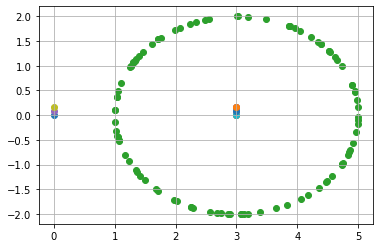

In [18]:
#  Stochastic 2D
d = dist(coordinates1, coordinates2)
w1 = np.zeros(3, dtype='complex')
H_list = [[0 for i in range(3)] for i2 in range(3)]
Hl = [[0, 0, 0],
     [0, 0, 0],
     [0, 0, 0]]
H_gbsm = np.array(H_list, dtype='complex')
K_rice = 3

N_size = 100
a_scat = -1 / np.sqrt(N_size*K_rice)
#r = np.random.exponential(scale=1.0, size = [1, N_size])+1.0
r = 2.0
azimuth = 2*np.pi*np.random.uniform(size = [1, N_size])
x_scat = r * np.cos(azimuth) +3.0
y_scat = r * np.sin(azimuth)
fig, ax = plt.subplots()

for i1 in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i1  
    
    ax.scatter(coord1[0], coord1[1])
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*i2  
        
        ax.scatter(coord2[0], coord2[1])
        
        d1 = dist(coord1, coord2)
        ray1 = (1/d1) * np.exp(-1j*k*d1)
        rays = ray1
        for i in range(N_size):
            scat_coord = np.array([x_scat[0,i], y_scat[0,i], 0.0])
            dist_scat = dist(coord1, scat_coord) + dist(scat_coord, coord2)
            scat_ray = a_scat * (1/dist_scat)*np.exp(-1j*k*dist_scat)
            rays += scat_ray
        a_ampl = (lyam/4/np.pi) * rays 
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        snr_db = a_db + 119 + 5.1
        snr = 10**(snr_db/20)
        H_gbsm[2-i1, 2-i2] = snr*np.exp(1j*ph2)
print(abs(H_gbsm))
p_gbsm = -57.3*np.arctan2(np.imag(H_gbsm), np.real(H_gbsm))
print(p_gbsm)

#fig, ax = plt.subplots()
ax.scatter(x_scat, y_scat)

plt.grid()
plt.savefig("a2.jpg")
plt.show()

In [19]:
# (New) Ray-based model
H_list = [[0 for i in range(3)] for i2 in range(3)]
H_det = np.array(H_list, dtype='complex')
#a_scat = -0.5
K_rice = 3
a_scat = -1 / np.sqrt(3*K_rice)
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*(i - 1)    
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*(i2 - 1)
        
        dist1 = dist(coord1, coord2)
        ray1 = (1/dist1) * np.exp(-1j*k*dist1)
        
        coord12 = list(coord1)
        coord12[1] = -(coord1[1] + 4)
        dist2 = dist(coord12, coord2)
        ray2 = a_scat*(1/dist2) * np.exp(-1j*k*dist2)
        
        coord13 = list(coord1)
        coord13[0] = -(coord1[0] + 6.2)
        dist3 = dist(coord13, coord2)
        ray3 = a_scat*(1/dist3) * np.exp(-1j*k*dist3)

        coord14 = list(coord1)
        coord14[2] = -coord1[2]
        dist4 = dist(coord14, coord2)
        ray4 = a_scat*(1/dist4) * np.exp(-1j*k*dist4)
        
        a_ampl = (lyam/4/np.pi) * (ray1 + ray2 + ray3 + ray4)
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        snr_db = a_db + 119 + 5.1
        snr = 10**(snr_db/20)
        H_det[2-i, 2-i2] = snr*np.exp(1j*ph2)
#w = np.linalg.eigvals((H@H))
#np.round(np.log2(abs(w)))
p_det = -57.3*np.arctan2(np.imag(H_det), np.real(H_det))
print(p_det)
abs(H_det)

[[ -6.52431206  -6.61725316 -15.30377546]
 [ -6.61725316  11.13043149   3.45141274]
 [-15.30377546   3.45141274  -3.19408051]]


array([[4286.30472896, 5275.59754728, 4642.66156417],
       [5275.59754728, 5001.74473109, 3886.96160692],
       [4642.66156417, 3886.96160692, 3826.85505455]])

In [55]:
# Free-space calculations
offset = 0.0
H_list = [[0 for i in range(3)] for i2 in range(3)]

H_fs = np.array(H_list, dtype='complex')
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i    
    for i2 in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*i2

        d1 = dist(coord1, coord2)
        line1 = (1/d1) * np.exp(-1j*k*d1)
        l1 = 1/d1
        coord2_inv = list(coord2)
        coord2_inv[2] = -coord2_inv[2]
        d2 = dist(coord1, coord2_inv)
        line2 = (1/d2) * np.exp(-1j*k*d2)
        a_ampl = (lyam/4/np.pi) * (line1)
        ph2 = -1*np.arctan2(np.imag(a_ampl), np.real(a_ampl))

        a_db = 20*np.log10(np.abs(a_ampl)) + G
        snr_db = a_db + 119 + 5.1
        snr = 10**(snr_db/20)
        H_fs[2-i, 2-i2] = snr*np.exp(1j*ph2)
p_fs = -57.3*np.arctan2(np.imag(H_fs), np.real(H_fs))
print(np.round(p_fs))
abs(H2)

[[ -0.  -8. -30.]
 [ -8.  -0.  -8.]
 [-30.  -8.  -0.]]


array([[4051.37187606, 4049.85931107, 4045.33176072],
       [4049.85931107, 4051.37187606, 4049.85931107],
       [4045.33176072, 4049.85931107, 4051.37187606]])

In [44]:
# Fading
K_rice = 3
H_fading = np.zeros([3, 3], dtype = 'complex')
N_fading_times = 1
for n in range(N_fading_times):
    H_NLOS = H_fs @ (np.random.randn(3,3)+1j*np.random.randn(3,3))*np.sqrt(1/2/(K_rice+1))
    H_LOS = H_fs * np.sqrt(K_rice/(K_rice+1))
    H_fad_tmp = H_NLOS + H_LOS
    H_fading += H_fad_tmp
H_fading /= N_fading_times
p_fading = -57.3*np.arctan2(np.imag(H_fading), np.real(H_fading))
print(p_fading)
abs(H_fading)

[[140.44556516  33.07406084   6.4864066 ]
 [157.86478756  30.25911284  15.92896986]
 [162.75111944  13.4791309   10.84229792]]


array([[4813.68804895, 2121.22321218, 5495.64888513],
       [4398.67888317, 2463.48648709, 6207.37850787],
       [4068.59685537, 2866.84682922, 6430.23373592]])

In [66]:
from scipy.linalg import fractional_matrix_power

#Rr = np.array([[1.0, 0.7, 0.4], [0.7, 1.0, 0.7], [0.4, 0.7, 1.0]])
Rr = np.array([[1.0, 0.9, 0.7], [0.9, 1.0, 0.9], [0.7, 0.7, 1.0]])
#Rr = np.array([[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]])
#Rt = np.array([[1.0, 0.6, 0.4], [0.6, 1.0, 0.6], [0.4, 0.6, 1.0]])
Rt = np.array(Rr)

Rr_half = fractional_matrix_power(Rr, 0.5)
Rt_half = fractional_matrix_power(Rt, 0.5)
Rt_half_H = np.conj(Rt_half).T

H_kron = np.dot(np.dot(H_fading, Rt_half_H), Rt_half_H)
#Hw = H_fading / np.max(H_fs)
#H_kron = np.dot(Rr_half, np.dot(H_fading, Rt_half_H))
coef = np.sum(abs(H_fading)) / np.sum(abs(H_kron))

p_kron = -57.3*np.arctan2(np.imag(H_kron), np.real(H_kron))
print(p_kron)
abs(H_kron*coef)

[[69.36239205 53.17166952 41.05878546]
 [63.03209836 48.0668666  39.02315783]
 [41.0956442  29.75050244 24.45272791]]


array([[3940.71994211, 4539.71966505, 4421.8023698 ],
       [3614.39914323, 4656.61415697, 4813.74328815],
       [3279.65517521, 4651.9680012 , 4947.15970318]])

In [69]:
# MAE
def mae(a,b):
    return (abs(a-b)).mean()

mae_fs1 = mae(ampl, abs(H_fs))
mae_fs2 = mae(phase0, -p_fs)

mae_det1 = mae(ampl, abs(H_det))
mae_det2 = mae(phase0, -p_det)

mae_gbsm1 = mae(ampl, abs(H_gbsm))
mae_gbsm2 = mae(phase0, -p_gbsm)

mae_fading1 = mae(ampl, abs(H_fading))
mae_fading2 = mae(phase0, -p_fading)

mae_kron1 = mae(ampl, abs(H_kron))
mae_kron2 = mae(phase0, -p_kron)

print(mae_fs1, mae_fs2)
print(mae_det1, mae_det2)
print(mae_gbsm1, mae_gbsm2)
print(mae_fading1, mae_fading2)
print(mae_kron1, mae_kron2)


592.5828867067553 50.34000634571248
511.6100168033556 48.76637493907999
819.8470401131657 48.192815273693185
1194.415645882367 99.07309339520205
1066.0815311824713 71.17859818657604


In [70]:
# ITUR 1238
N = 30
log_f = 20*np.log10(fc*10**-6)
for i in range(3):
    coord1 = list(coordinates1)
    coord1[1] = delta_d*i    
    for j in range(3):
        coord2 = list(coordinates2)
        coord2[1] = delta_d*j
        d = dist(coord1, coord2)
        L_itur = log_f + N*np.log10(d) - 28
        snr_itur = Pt - L_itur + 100 + 16
        snr = 10**(snr_itur/20)